<h1>Data setup</h1>
<h2>Use our function to read the data file</h2>

In [1]:
def read_311_data(datafile):
    import pandas as pd
    import numpy as np
    
    #Add the fix_zip function
    def fix_zip(input_zip):
        try:
            input_zip = int(float(input_zip))
        except:
            try:
                input_zip = int(input_zip.split('-')[0])
            except:
                return np.NaN
        if input_zip < 10000 or input_zip > 19999:
            return np.NaN
        return str(input_zip)
    
    #Read the file
    df = pd.read_csv(datafile,index_col='Unique Key')
    
    #fix the zip
    df['Incident Zip'] = df['Incident Zip'].apply(fix_zip)
    
    #drop all rows that have any nans in them (note the easier syntax!)
    
    df = df.dropna(how='any')
    
    #get rid of unspecified boroughs
    df = df[df['Borough'] != 'Unspecified']
    
    #Convert times to datetime and create a processing time column
    
    import datetime
    df['Created Date'] = df['Created Date'].apply(lambda x:datetime.datetime.strptime(x,'%m/%d/%Y %I:%M:%S %p'))
    df['Closed Date'] = df['Closed Date'].apply(lambda x:datetime.datetime.strptime(x,'%m/%d/%Y %I:%M:%S %p'))
    df['processing_time'] =  df['Closed Date'] - df['Created Date']
    
    #Finally, get rid of negative processing times and return the final data frame
    
    df = df[df['processing_time']>=datetime.timedelta(0,0,0)]
    
    return df
    

In [2]:
datafile = "nyc_311_data_subset-2.csv"
data = read_311_data(datafile)

C:\Users\umut\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2903: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


<h1>Plotting data on google maps</h1>
<h2>gmplot library</h2>
https://github.com/vgm64/gmplot

In [3]:
!pip install gmplot --upgrade

  Stored in directory: C:\Users\umut\AppData\Local\pip\Cache\wheels\81\6a\76\4dd6a7cc310ba765894159ee84871e8cd55221d82ef14b81a1
Successfully built gmplot


You should consider upgrading via the 'python -m pip install --upgrade pip' command.


<h3>Our data dataframe contains latitudes and longitudes for each complaint.</h3>
<h3>We can draw a heatmap that will help us see the relative concentration of complaints using lats and lons</h3>



<h3>Set up the map</h3>
<h4>GoogleMapPlotter constructor</h4>
<ul>
<li>GoogleMapPlotter(center_lat, center_lng, zoom)
<li>from_geocode(location_string,zoom)


In [9]:

import gmplot
gmap = gmplot.GoogleMapPlotter(40.7128, 74.0059, 8)


#gmap = gmplot.GoogleMapPlotter.from_geocode("New York",10)


<h3>Then generate the heatmap passing the two data series (latitude and longitude) to the function</h3>

In [10]:
#Then generate a heatmap using the latitudes and longitudes
gmap.heatmap(data['Latitude'], data['Longitude'])

<h3>Save the heatmap to an html file</h3>
<h4>The html file can be viewed, printed, or included in another html page</h4>

In [11]:
gmap.draw('incidents3.html')

<h1>Let's do some grouping operations</h1>

<h2>Incidents by Borough</h2>

In [12]:
%matplotlib inline

<h2>Group data by borough and plot a bar chart of the incident count</h2>

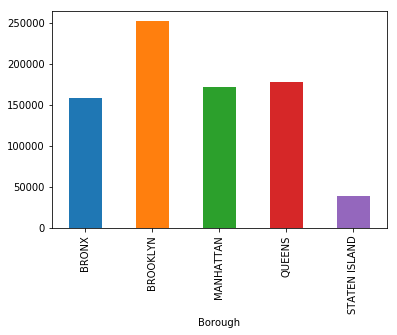

In [13]:

borough_group = data.groupby('Borough')
borough_group.size().plot(kind='bar')
#kind can be 'hist', 'scatter'

<h1>Incidents by Agency</h1>

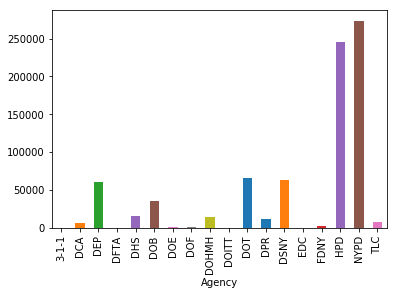

In [14]:
agency_group = data.groupby('Agency')
agency_group.size().plot(kind='bar')

<h2>Let's combine the two in a single graph</h2>


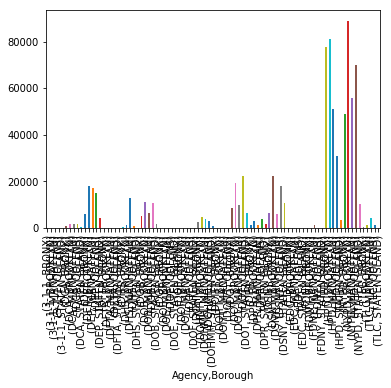

In [15]:

agency_borough = data.groupby(['Agency','Borough'])
agency_borough.size().plot(kind='bar')


<h2>This is quite unreadable and pointless!</h2>

<h3>We can unstack the groups so that we get borough by agency</h3>

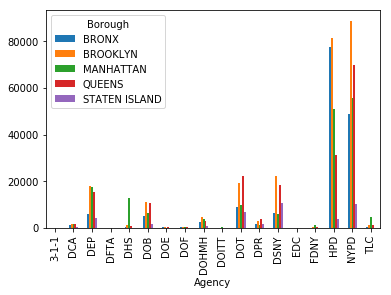

In [16]:
agency_borough.size().unstack().plot(kind='bar')

<h3>Increase the size of the image and add a title</h3>

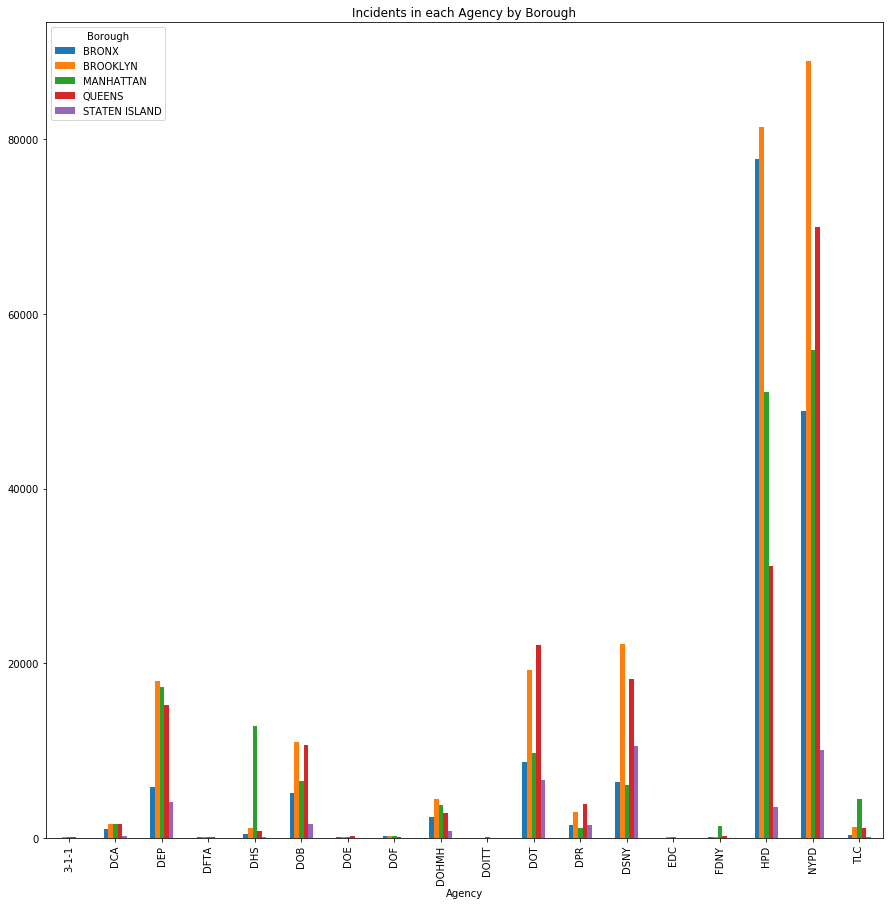

In [17]:

agency_borough = data.groupby(['Agency','Borough'])
agency_borough.size().unstack().plot(kind='bar',title="Incidents in each Agency by Borough",figsize=(15,15))


<h1>Digression: The pandas groupby function</h1>

<h4>You can use functions to group data</h4>

In [18]:
import pandas as pd
writers = pd.DataFrame({'Author':['George Orwell','John Steinbeck',
                                  'Pearl Buck','Agatha Christie'],
                        'Country':['UK','USA','USA','UK'],
                        'Gender':['M','M','F','F'],
                        'Age':[46,66,80,85]})
                        


In [19]:
writers

,Author,Country,Gender,Age
0,George Orwell,UK,M,46
1,John Steinbeck,USA,M,66
2,Pearl Buck,USA,F,80
3,Agatha Christie,UK,F,85


<h4>Group by country</h4>

In [24]:
grouped = writers.groupby('Country')
#grouped.first()
#grouped.last()
#grouped.sum()
#grouped.mean()
grouped.apply(sum)

,Author,Country,Gender,Age
Country,,,,
UK,George OrwellAgatha Christie,UKUK,MF,131
USA,John SteinbeckPearl Buck,USAUSA,MF,146


In [25]:
grouped.groups

{'UK': Int64Index([0, 3], dtype='int64'),
 'USA': Int64Index([1, 2], dtype='int64')}

<h4>Group by multiple columns</h4>

In [26]:
grouped = writers.groupby(['Country','Gender'])
grouped.groups

{('UK', 'F'): Int64Index([3], dtype='int64'),
 ('UK', 'M'): Int64Index([0], dtype='int64'),
 ('USA', 'F'): Int64Index([2], dtype='int64'),
 ('USA', 'M'): Int64Index([1], dtype='int64')}

<h4>Group by age groups</h4>

In [27]:
def age_groups(df,index,col):
    print(index,col)
    if df[col].iloc[index] < 30:
        return 'Young'
    if df[col].iloc[index] < 60:
        return 'Middle'
    else:
        return 'Old'

In [28]:
writers['Age'].iloc[0]

46

In [29]:
grouped = writers.groupby(lambda x: age_groups(writers,x,'Age'))
grouped.groups

0 Age
1 Age
2 Age
3 Age


{'Middle': Int64Index([0], dtype='int64'),
 'Old': Int64Index([1, 2, 3], dtype='int64')}

<h2>Grouping by the values in a column</h2>
<h3>For example, grouping the data by values in a column that are greater than or less than zero</h3>

In [30]:
import numpy as np
import pandas as pd
people = pd.DataFrame(np.random.randn(5, 5), columns=['a', 'b', 'c', 'd', 'e'], index=['Joe', 'Steve', 'Wes', 'Jim', 'Travis'])
people

,a,b,c,d,e
Joe,-1.821454,-2.415337,-0.699356,0.578304,0.359439
Steve,0.330363,-0.255433,-2.057362,0.318440,1.642940
Wes,-0.994335,-0.996196,-1.090023,0.522331,1.578764
Jim,-2.615947,0.430332,-1.261291,1.103371,-3.571041
Travis,-1.776344,1.460622,0.536844,-1.025699,-0.417669


<h3>Write a function that takes three arguments - a dataframe, an index, and a column name and returns the grouping for that row</h3>

In [31]:
def GroupColFunc(df, ind, col):
    if df[col].loc[ind] > 0:
        return 'Group1'
    else:
        return 'Group2'

In [32]:
people.groupby(lambda x: GroupColFunc(people, x, 'a')).groups

{'Group1': Index(['Steve'], dtype='object'),
 'Group2': Index(['Joe', 'Wes', 'Jim', 'Travis'], dtype='object')}

<h2>Now we can compute stats on these groups</h2>

In [33]:
print(people.groupby(lambda x: GroupColFunc(people, x, 'a')).mean())
print(people.groupby(lambda x: GroupColFunc(people, x, 'a')).std())

               a         b         c         d         e
Group1  0.330363 -0.255433 -2.057362  0.318440  1.642940
Group2 -1.802020 -0.380145 -0.628457  0.294577 -0.512627
               a         b         c         d         e
Group1       NaN       NaN       NaN       NaN       NaN
Group2  0.662286  1.689854  0.811681  0.918268  2.198282


<h1>Incidents by time</h1>
<p>We know the creation date of each incident so we can build a bar graph of number of incidents by month
<p>Not particularly useful with a few months data but if we had all data from 2010, we could use this sort of
analysis to eyeball trends and seasonality
<p>We're going to need to do some data manipulation for this

<h3>We'll start by creating a new date field yyyymm

In [34]:
import datetime
data['yyyymm'] = data['Created Date'].apply(lambda x:datetime.datetime.strftime(x,'%Y%m'))

In [35]:
data['yyyymm']

Unique Key
1    201609
1    201609
1    201609
1    201609
1    201609
1    201609
1    201609
1    201609
1    201609
1    201609
1    201609
1    201609
1    201609
1    201609
1    201609
1    201609
1    201609
1    201609
1    201609
1    201609
1    201609
1    201609
1    201609
1    201609
1    201609
1    201609
1    201609
1    201609
1    201609
1    201609
      ...  
1    201609
1    201609
1    201609
1    201609
1    201609
1    201609
1    201609
1    201609
1    201609
1    201609
1    201609
1    201609
1    201609
1    201609
1    201609
1    201609
1    201609
1    201609
1    201609
1    201609
1    201609
1    201609
1    201609
1    201609
1    201609
1    201609
1    201609
1    201609
1    201609
1    201609
Name: yyyymm, Length: 799323, dtype: object

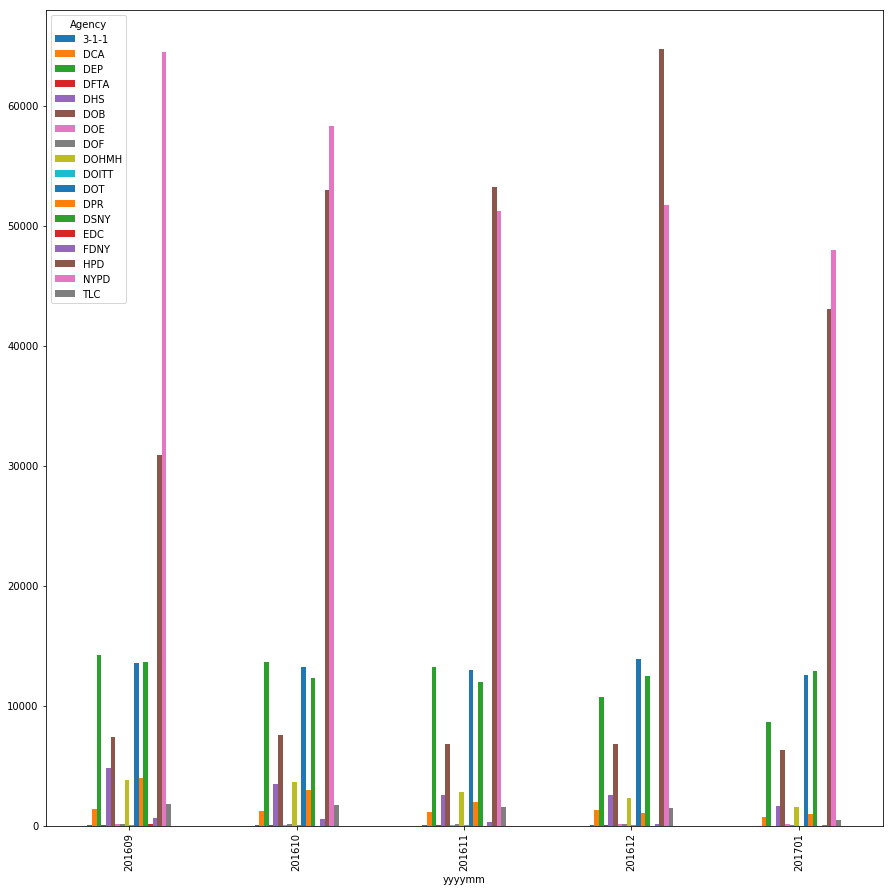

In [36]:
date_agency = data.groupby(['yyyymm','Agency'])
date_agency.size().unstack().plot(kind='bar',figsize=(15,15))

<h1>Examining agencies</h1>

<h2>We'll look at the frequency by agency and report the top 5 values</h2>

In [37]:
data.groupby('Agency').size().sort_values(ascending=False)

Agency
NYPD     273683
HPD      244815
DOT       66178
DSNY      63321
DEP       60346
DOB       34821
DHS       15083
DOHMH     14188
DPR       10830
TLC        7129
DCA        5760
FDNY       1676
DOF         579
DOE         454
DOITT       134
EDC         123
3-1-1       102
DFTA        101
dtype: int64

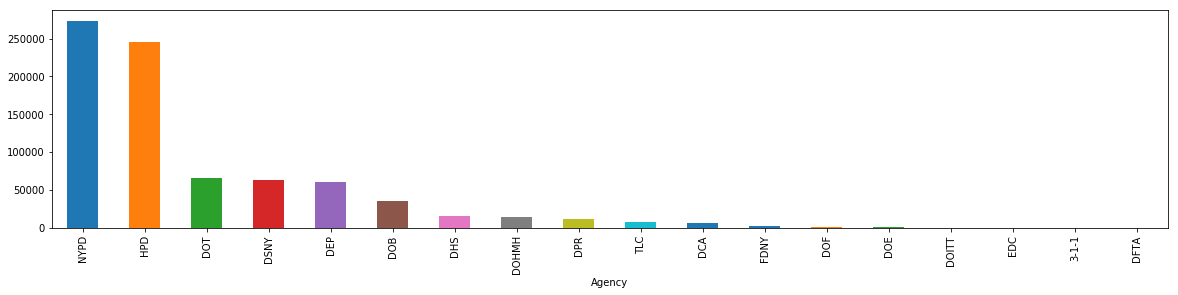

In [38]:
data.groupby('Agency').size().sort_values(ascending=False).plot(kind='bar', figsize=(20,4))

<h3>We can drill down into complaints by Agency by borough</h3>

In [42]:
for i, (label, col) in enumerate (agency_borough.iteritems()):
    print (i, label, col)

0 BRONX Agency
3-1-1       17.0
DCA        958.0
DEP       5837.0
DFTA        21.0
DHS        397.0
DOB       5160.0
DOE        129.0
DOF        143.0
DOHMH     2406.0
DOITT        7.0
DOT       8682.0
DPR       1416.0
DSNY      6406.0
EDC          1.0
FDNY        39.0
HPD      77774.0
NYPD     48837.0
TLC        318.0
Name: BRONX, dtype: float64
1 BROOKLYN Agency
3-1-1       28.0
DCA       1532.0
DEP      17917.0
DFTA        33.0
DHS       1130.0
DOB      10993.0
DOE        127.0
DOF        161.0
DOHMH     4481.0
DOITT       18.0
DOT      19176.0
DPR       2929.0
DSNY     22208.0
EDC         62.0
FDNY       127.0
HPD      81382.0
NYPD     88973.0
TLC       1238.0
Name: BROOKLYN, dtype: float64
2 MANHATTAN Agency
3-1-1       23.0
DCA       1529.0
DEP      17315.0
DFTA        24.0
DHS      12767.0
DOB       6507.0
DOE         49.0
DOF        153.0
DOHMH     3759.0
DOITT       91.0
DOT       9673.0
DPR       1103.0
DSNY      6079.0
EDC         41.0
FDNY      1344.0
HPD      51017.0
NYPD 

In [39]:
agency_borough = data.groupby(['Agency', 'Borough']).size().unstack()

In [40]:
agency_borough

Borough,BRONX,BROOKLYN,MANHATTAN,QUEENS,STATEN ISLAND
Agency,,,,,
3-1-1,17.0,28.0,23.0,28.0,6.0
DCA,958.0,1532.0,1529.0,1547.0,194.0
DEP,5837.0,17917.0,17315.0,15216.0,4061.0
DFTA,21.0,33.0,24.0,21.0,2.0
DHS,397.0,1130.0,12767.0,734.0,55.0
DOB,5160.0,10993.0,6507.0,10567.0,1594.0
DOE,129.0,127.0,49.0,136.0,13.0
DOF,143.0,161.0,153.0,112.0,10.0
DOHMH,2406.0,4481.0,3759.0,2814.0,728.0


<h3>We can create 'top 5 Agency' subplots subplots for each borough</h3>

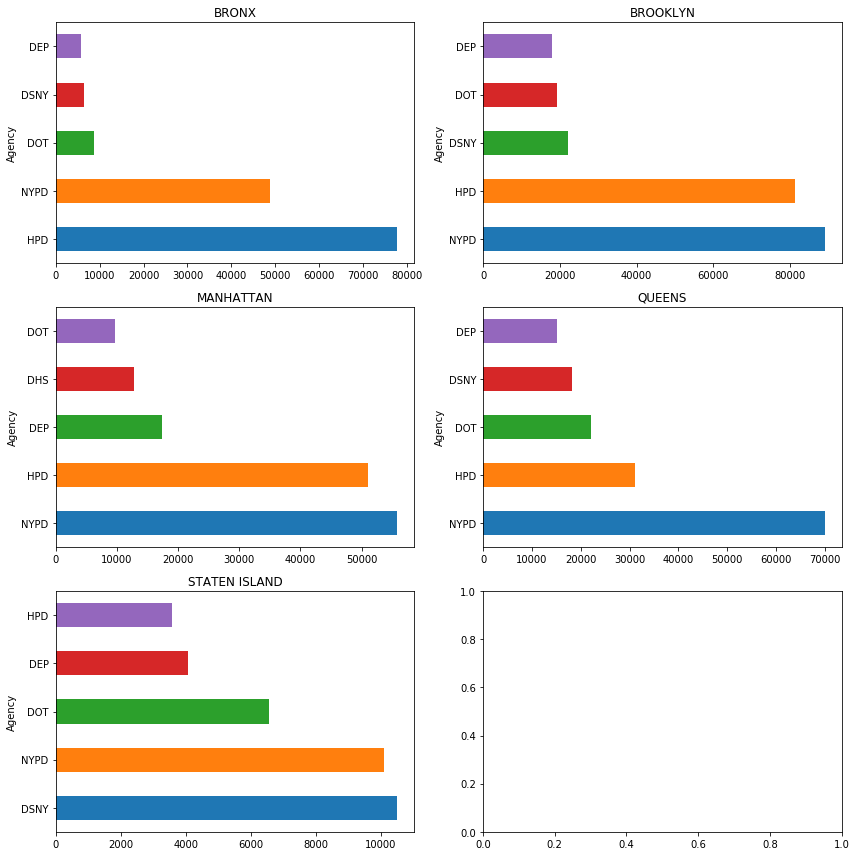

In [43]:
#We'll arrange the subplots in two rows and three columns. 
#Since we have only 5 boroughs, one plot will be blank
COL_NUM = 2
ROW_NUM = 3
import matplotlib.pyplot as plt
fig, axes = plt.subplots(ROW_NUM, COL_NUM, figsize=(12,12))

for i, (label, col) in enumerate(agency_borough.iteritems()): 
    ax = axes[int(i/COL_NUM), i%COL_NUM]
    col = col.sort_values(ascending=False)[:5] 
    col.plot(kind='barh', ax=ax)
    ax.set_title(label)

plt.tight_layout() 

In [ ]:
for i, (label, col) in enumerate(agency_borough.iteritems()): 
    print(i,label,col)

<h1>Processing time</h1>
<h2>We can compute simple statistics on processing time</h2>

In [44]:
grouped = data[['processing_time','Borough']].groupby('Borough')

In [45]:
grouped.describe()

processing_time                          \
                        count                    mean   
Borough                                                 
BRONX                  158548  5 days 11:22:39.529133   
BROOKLYN               252515  5 days 01:22:08.762913   
MANHATTAN              171708  5 days 07:43:58.957480   
QUEENS                 177641  4 days 22:17:46.753142   
STATEN ISLAND           38911  5 days 00:57:16.541826   

                                                         \
                                   std              min   
Borough                                                   
BRONX          10 days 19:29:45.763262  0 days 00:00:00   
BROOKLYN       11 days 20:44:39.914032  0 days 00:00:00   
MANHATTAN      12 days 01:57:03.858305  0 days 00:00:00   
QUEENS         13 days 02:00:32.516708  0 days 00:00:00   
STATEN ISLAND  12 days 00:18:49.372858  0 days 00:00:00   

                                                               \
                                  25%                     50%   
Borough                                                         
BRONX          0 days 05:48:38.250000         1 days 21:27:00   
BROOKLYN       0 days 02:33:20.500000         0 days 20:19:00   
MANHATTAN             0 days 02:03:43  0 days 22:13:02.500000   
QUEENS                0 days 02:07:59         0 days 10:15:11   
STATEN ISLAND         0 days 02:54:00         0 days 22:11:06   

                                                          
                                  75%                max  
Borough                                                   
BRONX          5 days 19:48:12.750000  145 days 00:23:57  
BROOKLYN              4 days 05:20:01  146 days 17:26:50  
MANHATTAN      4 days 11:06:08.500000  139 days 22:41:59  
QUEENS                3 days 20:47:00  148 days 13:10:54  
STATEN ISLAND         4 days 15:24:28  139 days 22:06:35

<h3>But it is easier to convert the timedelta processing_time into floats for calculation purposes</h3>

In [46]:
import numpy as np
#The time it takes to process. Cleaned up
data['float_time'] =data['processing_time'].apply(lambda x:x/np.timedelta64(1, 'D'))

In [47]:
data

,Created Date,Closed Date,Agency,Incident Zip,Borough,Latitude,Longitude,processing_time,yyyymm,float_time
Unique Key,,,,,,,,,,
1,2016-09-01 00:33:42,2016-09-16 01:06:56,DCA,10001,MANHATTAN,40.744790,-73.988834,15 days 00:33:14,201609,15.023079
1,2016-09-01 20:16:24,2016-09-10 18:08:25,HPD,11691,QUEENS,40.600554,-73.750704,8 days 21:52:01,201609,8.911123
1,2016-09-01 12:17:00,2016-09-07 12:00:00,DSNY,11211,BROOKLYN,40.704925,-73.962007,5 days 23:43:00,201609,5.988194
1,2016-09-01 12:10:22,2016-09-10 14:23:44,HPD,10027,MANHATTAN,40.812322,-73.955338,9 days 02:13:22,201609,9.092616
1,2016-09-01 12:32:32,2016-09-11 02:03:37,HPD,10452,BRONX,40.839529,-73.922534,9 days 13:31:05,201609,9.563252
1,2016-09-01 20:16:24,2016-09-10 18:08:24,HPD,11691,QUEENS,40.600554,-73.750704,8 days 21:52:00,201609,8.911111
1,2016-09-01 08:35:00,2016-09-07 12:00:00,DSNY,11428,QUEENS,40.721866,-73.745982,6 days 03:25:00,201609,6.142361
1,2016-09-01 13:19:42,2016-09-16 14:32:35,DOT,11101,QUEENS,40.746875,-73.952711,15 days 01:12:53,201609,15.050613
1,2016-09-01 11:00:00,2016-09-08 12:00:00,DSNY,10075,MANHATTAN,40.773336,-73.955054,7 days 01:00:00,201609,7.041667


<h2>Now we can compute stats easily</h2>

In [48]:
grouped = data[['float_time','Agency']].groupby('Agency')
grouped.mean().sort_values('float_time',ascending=False)

,float_time
Agency,
EDC,49.604041
FDNY,32.995208
DPR,24.395774
TLC,24.196724
DOITT,18.300134
DOHMH,15.897552
DOB,12.345634
DOE,11.360792
DCA,9.254590


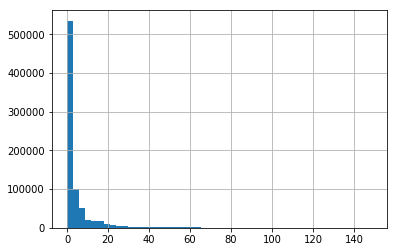

In [49]:
data['float_time'].hist(bins=50)

<h1>Other useful visualization libraries</h1>
<h2>seaborn: https://seaborn.pydata.org/</h2>
<h2>bokeh: http://bokeh.pydata.org/en/latest/</h2>
<h2>plotly: https://plot.ly/</h2>
